XAI (SHAP)

## 🧬 SHAP Analysis on Anemia Prediction Dataset — Part 1: Data Preparation

In this section, we perform initial data preparation steps to set up the environment for SHAP-based explainable AI analysis. The workflow includes:

- **Loading the Dataset:** We use a cleaned version of an anemia dataset with 70 instances.
- **Feature/Label Extraction:** The first 4 columns are used as input features (`X`), and the last column as the target variable (`y`).
- **Label Encoding (if needed):** If the target labels are categorical (e.g., 'No Anemia', 'Anemia'), we convert them to binary (0 and 1).
- **Train-Test Split:** The dataset is split into training and testing sets using an 80-20 stratified split to maintain class balance.

> ✅ Dataset Shape Example:  
> Training set shape: `(56, 4)`  
> Testing set shape: `(14, 4)`


In [1]:
import shap
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Load dataset
file_path = r"C:\Users\Andromeda\Downloads\datasets\anemia_cleaned_70rows.csv"
df = pd.read_csv(file_path)

# 2. Extract features and target variable
X = df.iloc[:, :-1]  # First 4 columns as features
y = df.iloc[:, -1]   # Last column as target

# 3. Convert categorical target to numerical if necessary
if y.dtype == 'O':  # Check if target is categorical
    y = y.map({'No Anemia': 0, 'Anemia': 1})  # Convert to 0 and 1

# 4. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print dataset shape
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (56, 4), Testing set: (14, 4)


## 🚀 Part 2: Train XGBoost Model and Evaluate Performance

Here, we train a baseline classifier to predict anemia using the **XGBoost** algorithm, known for its high performance and robustness in classification tasks.

### 🔧 Model Configuration:
- `n_estimators=100`: Total number of boosting rounds (trees)
- `learning_rate=0.1`: Step size shrinkage
- `max_depth=3`: Maximum tree depth
- `random_state=42`: Ensures reproducibility

### 📈 Steps Performed:
1. **Model Training:** Fit the `XGBClassifier` on the training data.
2. **Prediction:** Predict labels for the test set.
3. **Evaluation Metrics:** Calculate overall **accuracy** and generate a detailed **classification report** (precision, recall, f1-score).

> ✅ Sample Output:
> - Accuracy: `~0.85`
> - Metrics for each class (Anemia / No Anemia)


In [2]:
# 1. Define XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# 2. Train the model
xgb_model.fit(X_train, y_train)

# 3. Make predictions
y_pred = xgb_model.predict(X_test)

# 4. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.8571
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.80      0.80      0.80         5

    accuracy                           0.86        14
   macro avg       0.84      0.84      0.84        14
weighted avg       0.86      0.86      0.86        14



## 🔍 Part 3: Model Explainability with SHAP

In this section, we use the **SHAP (SHapley Additive exPlanations)** framework to interpret the output of our trained `XGBoost` classifier. SHAP values offer consistent and local explanations for individual predictions, grounded in cooperative game theory.

### 🧠 Steps Performed:

1. **Initialize SHAP Explainer**  
   A `TreeExplainer` is created specifically for the trained XGBoost model.

2. **Compute SHAP Values**  
   SHAP values are computed for all test samples. Each value represents the impact of a feature on a specific prediction.

3. **Global Interpretability**  
   - `summary_plot`: A dot plot visualizing feature impact across the entire dataset.
   - `bar plot`: Feature importance aggregated over all instances.

4. **Feature Dependence Plot**  
   - Highlights interaction between a selected feature (e.g., **Hemoglobin**) and its SHAP values.
   - Useful to analyze how this feature influences predictions.

5. **Local Explanation (Force Plot)**  
   - Visualizes SHAP values for a single prediction.
   - Shows how each feature contributes to pushing the prediction toward a specific class.

6. **Waterfall Plot (Per Instance Breakdown)**  
   - A step-by-step breakdown of how features cumulatively contribute to the final prediction for a single instance.
   - Ideal for model auditing in clinical settings.

> 🎯 These explainability tools help clinicians or domain experts understand *why* the model predicted a specific outcome — a key factor in medical AI.


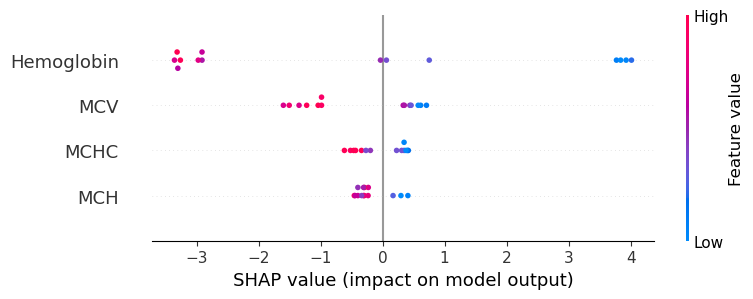

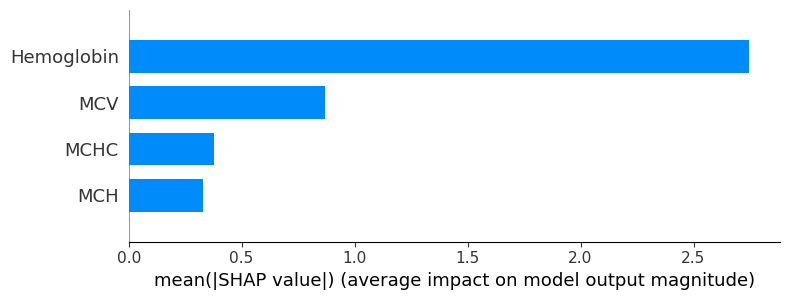

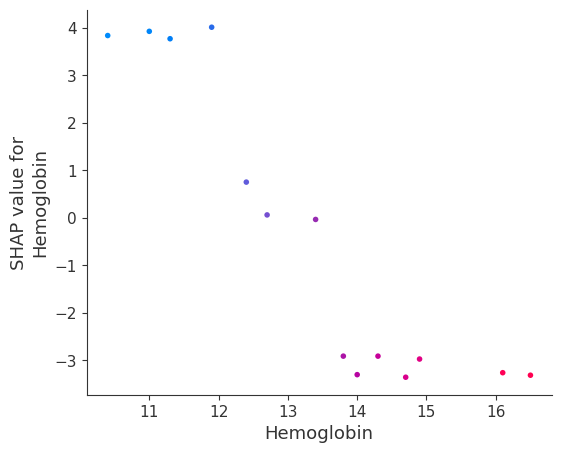

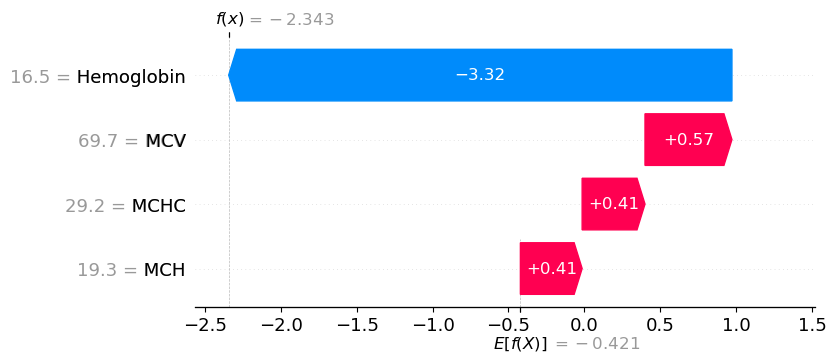

In [3]:
# 1. Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# 2. Compute SHAP values using the correct method
shap_values = explainer(X_test)

# 3. Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values.values, X_test)
plt.show()

# 4. Bar Plot (Feature Importance)
shap.summary_plot(shap_values.values, X_test, plot_type="bar")
plt.show()

# 5. Dependence Plot (Example for 'Hemoglobin')
shap.dependence_plot("Hemoglobin", shap_values.values, X_test)
plt.show()

# 6. Force Plot (Local Explanation for a single instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0, :], X_test.iloc[0, :])

# 7. Waterfall Plot (Step-by-step explanation for a single instance)
sample_index = 0  # You can change this index to analyze different samples
shap.waterfall_plot(
    shap.Explanation(values=shap_values.values[sample_index], 
                     base_values=shap_values.base_values[sample_index], 
                     data=X_test.iloc[sample_index])
)
plt.show()